In [45]:
# General imports
from IPython.display import Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from supreme_court_predictions.models.logistic_regression import (
    LogisticRegression,
)
from supreme_court_predictions.models.random_forest import RandomForest
from supreme_court_predictions.models.xg_boost import XGBoost

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [2]:
# Setup - Datasets
LABELS = np.array(["for respondent", "for petitioner"])


# Loading dataframes
from supreme_court_predictions.util.functions import get_full_data_pathway

# Loading unprocessed dataframes
data_path = get_full_data_pathway("clean_convokit/")
utterances = pd.read_csv(data_path + "utterances_df.csv")
advocates = pd.read_csv(data_path + "advocates_df.csv")
cases = pd.read_csv(data_path + "cases_df.csv")
conversations = pd.read_csv(data_path + "conversations_df.csv")
speakers = pd.read_csv(data_path + "speakers_df.csv")
voters = pd.read_csv(data_path + "voters_df.csv")

# Loading processed dataframes
proc_data_path = get_full_data_pathway("processed/")
cases_proc = pd.read_pickle(proc_data_path + "case_aggregations.p")
judges_proc = pd.read_pickle(proc_data_path + "judge_aggregations.p")
adversary_proc = pd.read_pickle(proc_data_path + "adversary_aggregations.p")
advocate_proc = pd.read_pickle(proc_data_path + "advocate_aggregations.p")

# Loading descriptive statistics
from supreme_court_predictions.summary_analysis.descriptive_statistics import (
    DescriptiveStatistics,
)

ds = DescriptiveStatistics()
ds.parse_all_data()

In [3]:
# Setup - Models and plots
# Load models
lr = LogisticRegression()
lr.run()

rf = RandomForest()
rf.run()

xg = XGBoost()
xg.run()

# Model Comparison DF - using advocate utterances
models = [
    "logistic regression",
    "random forest",
    "xg boost",
]  
accuracy = [
    lr.accuracies["adversary_aggregations"],
    rf.accuracies["adversary_aggregations"],
    xg.accuracies["adversary_aggregations"],
]  
f1 = [
    lr.f1["adversary_aggregations"],
    rf.f1["adversary_aggregations"],
    xg.f1["adversary_aggregations"],
]  

model_comp = {"model": models, "accuracy": accuracy, "f1_score": f1}
model_comp = pd.DataFrame.from_dict(model_comp)


# Setup for plots
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

In [4]:
# Helper Functions
def dict_to_df(column_names, dict1, dict2=None):
    """
    Transforms a dictionary to a dataframe for better presentation.

    :param column_names (list): List of column names for dataframe.
    :param dict1 (dictionary): Dictionary of data to convert.
    :param dict1 (dictionary, optional): Dictionary of data to convert.
    : return (DataFrame) DataFrame representation of dictionary.
    """

    df = {}
    df[column_names[0]] = list(dict1.keys())
    df[column_names[1]] = list(dict1.values())

    if dict2 != None:
        df[column_names[2]] = list(dict2.values())

    df = pd.DataFrame.from_dict(df)

    return df


def disp_accuracy(df, labs, x_label="Dataset"):
    """
    Creates a barchart representing the accuracy and f1 scores of a dataset.

    :param df (DataFrame) Dataframe with three columns: dataset name, accuracy
                          score, and F1 score.
    """
    # set width of bar
    barWidth = 0.25
    fig = plt.subplots(figsize=(12, 8))

    # set height of bar
    accs = list(df["accuracy"])
    f1 = list(df["f1_score"])

    # Set position of bar on X axis
    br1 = np.arange(len(df))
    br2 = [x + barWidth for x in br1]

    # Make the plot
    plt.bar(
        br1,
        accs,
        color="gray",
        width=barWidth,
        edgecolor="grey",
        label="Accuracy",
    )
    plt.bar(
        br2,
        f1,
        color="blue",
        width=barWidth,
        edgecolor="grey",
        label="F1 Score",
    )

    # Adding Xticks
    plt.xlabel(x_label, fontweight="bold", fontsize=15)
    plt.ylabel("Prop Correct Prediction", fontweight="bold", fontsize=15)
    plt.xticks(
        [r + barWidth for r in range(len(accs))],
        labs,
    )

    plt.legend()
    plt.show()


def disp_conf_matrix(cm):
    """
    Creates a plot of the confusion matrix.

    :param cm (array): Confusion matrix to display.
    """
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=LABELS,
    )
    disp.plot()
    plt.show()

### Finetuning Functions

In [42]:
# Value columns for long format
value_cols = [
    "case_aggregations",
    "judge_aggregations",
    "advocate_aggregations",
    "adversary_aggregations",
]


def get_long_df(param_name, param_values, accuracy_dicts, f1_dicts):
    """
    Converts the accuracy dataframes to long format for
    posterior plotting
    """
    # Dataframe of accuracy and f1 scores
    acc_df = pd.DataFrame.from_dict(accuracy_dicts)
    f1_df = pd.DataFrame.from_dict(f1_dicts)

    # Add parameter values to dataframe
    acc_df[param_name] = param_values
    f1_df[param_name] = param_values

    # Convert to long format
    acc_melted = acc_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )
    f1_melted = f1_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )

    return acc_melted, f1_melted

In [39]:
def plot_accuracy_scores(
    melted_df, param_name, model_name, accuracy_metric=None
):
    """
    Plots accuracy scores when finetuning a parameter

    Parameters
    ----------
    param_name : str
        Name of parameter being finetuned
    melted_df : pandas dataframe
        Dataframe with accuracy scores in long format
    """
    fig_dims = (10, 12)
    fig, ax1 = plt.subplots(figsize=fig_dims)
    ax1 = sns.lineplot(
        x=param_name,
        y="value",
        data=melted_df,
        hue="type",
        style="type",
        markers=True,
        dashes=False,
    )
    fig.set_size_inches(12.7, 9.27)
    plt.ticklabel_format(style="plain", axis="y")
    if accuracy_metric is None:
        ax1.set_title(
            f"Accuracy Score - {model_name} - {param_name} parameter finetuning (test set)",
            fontsize=18,
        )
        ax1.set_ylabel("Accuracy Score", fontsize=16)
    else:
        ax1.set_title(
            f"{accuracy_metric} Score - {model_name} - {param_name} parameter finetuning (test set)",
            fontsize=18,
        )
        ax1.set_ylabel(f"{accuracy_metric} Score", fontsize=16)

    ax1.set_xlabel(param_name, fontsize=16)
    plt.legend(bbox_to_anchor=(1.25, 1), loc="upper right", borderaxespad=0)

    plt.show()

## Machine Learning Final Presentation
### Predicting Outcomes of US Supreme Court Oral Arguments
**Team Members: Federico Dominguez, Chanteria Milner, Jessup Jong, Michael Plunkett**

## Background
- <b>Dataset</b>: Supreme Court Oral Arguments Corpus
- <b>Souce</b>: Court transcripts from [oyez.org](https://www.oyez.org/), voting information from [Supreme Court Dataset](http://scdb.wustl.edu/index.php)
- <b>Goal</b>: Predict case decision using case transcripts and NLP models


## Introduction
The project uses historic United States Supreme Court cases to train natural language processing models to predict case rulings.

This task of predicting case rulings is **important** because it presents insights into the decision making process of the Supreme Court. Prediction through machine learning can help find patterns and anticipate systematic legal trends. **Stakeholders** interested in a case prediction project could be **academics, judges, litigants, policymakers, and the public.** This prediction tool can guide litigation strategies for litigants such as law firms. The general public may also be interested in these predictions from the viewpoint of transparency in decision making. For most practitioners in law, the actual decision as a result of majority vote may not as be useful compared to the specific reasoning used in each justices' opinions. Splitting up the machine learning into smaller subsets, therefore, can be more useful information to stakeholders.

The legal theory behind a machine learning project that predicts case rulings can be traced back to a few main schools of thought including **empirical legal studies** where one uses social scientific methods to build a predictive model. Without siding to one side, this project is able to follow **legal realism** and to a certain extent **behavioralism.** Predictions of case rulings trained on utterances assumes that decisions are based on personal views and patterns of decisions. This approach is vulnerable to criticism from **legal positivism, critical legal studies, and law and economics** where decisions are viewed either solely as results based on written regulations and precedents (positivism), social, economic, and political context (critical studies), and economic incentives (law and economics).

## Datasets
### Six total datasets
1. Cases
2. Speakers
3. Voters
4. Advocates
5. Conversations
6. Utterances


### Case Information
Includes infromation on each <i>court case</i>, such as:
- Unique case ID
- Year and title of case
- Case petitioner and respondent
- Winning side (1 = for petitioner) and decision date

In [6]:
ds.cases_stats

counts  percentages
win side             for petitioner   284.0    66.510539
                     for respondent   143.0    33.489461
cases                                 427.0          NaN
courts                                  1.0          NaN
years (2014 to 2019)                    6.0          NaN
petitioners                           413.0          NaN
respondents                           356.0          NaN

### Speakers
Includes infromation on each <i>speaker</i>, such as:
- Speaker name and unique speaker key
- Speaker role and type (justice, advocate, nan)

In [7]:
ds.speakers_stats

counts  percentages
speaker type  advocate (A)  8942.0    99.610115
              justice (J)     35.0     0.389885
speaker names               8928.0          NaN
speaker keys                8977.0          NaN

### Voters
Includes infromation on each <i>vote and voter</i>, such as:
- Unique case ID
- Voter key and vote side (judges only, 1=for petitioner)

In [8]:
ds.voters_stats.head(7)

counts percentages
votes    for petitioner        1912.0   60.659898
         for respondent        1240.0   39.340102
justices                         11.0         NaN
justice  j__john_g_roberts_jr     363    0.661157
         j__antonin_scalia         66    0.651515
         j__anthony_m_kennedy     240    0.658333
         j__clarence_thomas       364    0.532967

### Advocates
Includes infromation on each <i>advocate (non-judges)</i>, such as:
- Unique case ID
- Advocate ID and advocacy side(1 = for petitioner)
- Advocate role

In [9]:
ds.advocates_stats

counts  percentages
side            for petitioner   403.0    50.124378
                for respondent   401.0    49.875622
total advocates                  391.0          NaN
total roles                      154.0          NaN
aggregate roles inferred          10.0     1.243781
                for respondent   404.0    50.248756
                for petitioner   390.0    48.507463

### Conversations
Includes infromation on each <i>conversation</i>. There is one conversation per case, <br>
and conversations are made up of individual utterances. Conversation information includes:

- Unique case ID
- Unique conversation ID
- Winning side (1 = for petitioner)

In [10]:
conversations.head(2)

,id,case_id,winning_side
0,23291,2014_13-553,1
1,23252,2014_13-895,1


### Utterances
Includes infromation on each <i>utterance</i>, such as:
- Unique case ID
- Corresponding conversation ID
- Speaker key
- Utterance text

In [11]:
cols = ["case_id", "speaker", "speaker_type", "conversation_id", "text"]

In [12]:
utterances.head(2).loc[:, cols]

,case_id,speaker,speaker_type,conversation_id,text
0,2014_13-553,j__john_g_roberts_jr,J,23291,"we'll hear argument next in case no. 13-553, t..."
1,2014_13-553,andrew_l_brasher,A,23291,"thank you, mr. chief justice, and may it pleas..."


## Data Cleaning and Pre-Processing
### Data Cleaning Steps:
1. Limited cases to those that ruled either for the petitioner or respondent (removed undetermined)
2. Removed cases with no utterances
3. Cleaned utterance text
4. Filtered cases to include last 5 years of dataset (2014-2019)


### Data Processing Steps
1. Tokenized utterance text
2. Created utterances dataframes that includes tokenized text, case id, year, and winning side. These dataframes corresponded to:
    -  All utterances within a case
    - Judge utterances within a case
    - Advocate (for petitioner) utterances within a case
    - Adversary (for respondent) utterances within a case

## Pre-processed Datasets
### All Utterances

In [13]:
cases_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",1


### Judge Utterances
In addition to standard columns, includes columns on count of advocates for petitioner or respondent.

In [14]:
judges_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",1


### Advocate Utterances

In [15]:
advocate_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",1
1,2014_13-895,"[mr, chief, justice, court, alabama, employ, r...",1


### Adversary Utterances

In [16]:
adversary_proc.head(2)

,case_id,tokens,win_side
0,2014_13-553,"[handpicked, business, transport, good, motor,...",1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",1


## Model and Evaulation Overviews
- Logistic Regression
- Gradient Boosted Tree Model
- Random Forest

### Logistic Regression

What is a Logistic Regression model? Logistic regression in machine learning is a supervised learning model that predicts the probability of a binary outcome based on training data. It is called a "supervised learning approach" because the model is trained on data where the outcome is known.

Logistic regression is also a classification model because it predicts the probability of a binary outcome, where it predicts if the petitioner, given the 'bag of words,' won or lost the case. It is also worth noting that regularization can be added to the model to prevent overfitting. Within our current model, we decided against using that feature.

**What are some limitations of the Logistic Regression model?**

Logistic regression is limited because it assumes a linear relationship between independent and dependent variables. It can also not consider the more complex relationships between the utterances and the Court decisions. It comes up short as the end-all-be-all model for our data since Supreme Court decisions and the speech uttered within them are not independent. Each case cannot be viewed within a vacuum but is instead influenced by precedents and the social trends of its time. Logistic regression may account for the association between verdicts and utterances. Still, it cannot explain or make any statements regarding causality.

**What were we able to conclude from our use of the Logistic Regression model?**

We applied logistic regression models to four different datasets and observed the below results. We used the following hyperparameters as defaults in our regression: a test size of 0.20, a random state of 123, and a maximum of 1000 iterations.

--Description of split in data

-- Results in results (bar chart)

All Utterances: This dataset comprises a bag of words created from all utterances in the cases between 2014 and 2019, including the judge, advocate, and adversary statements. The model achieved an accuracy of 54.05%, slightly better than random chance.

Judge Utterances: This dataset only focuses on a bag of words from judge statements. The model's accuracy was 52.05%, underperforming compared to the model using all utterances.

Advocate Utterances: Using a bag of words created solely from advocate statements, the model achieved an accuracy of 75.67%, significantly outperforming the model using all utterances.

Adversary Utterances: This dataset consists of a bag of words derived only from adversary statements. The model obtained an accuracy of 78.37%, outperforming all other models and emerging as the best performer.

In conclusion, models using advocate and adversary utterances independently have higher predictive power than models using judge utterances or a combination of all utterances.

### Gradient Boosted Tree Model

XG Boost, short for Extreme Gradient Boosting is a tree ensemble model that uses gradient boosting to minimize the loss function. In XG Boost, each tree is grown sequentially, taking into account the previous tree's residuals and reweighting the observations accordingly.

XG Boost is called an "ensemble model" because it uses several "weak learners" (decision trees, in this case) to obtain a more robust model by adjusting the tree model on every iteration. It is different than Random Forest because, instead of averaging all of the weak learners' results to make the final prediction, it adjusts the model on every iteration by using the previous model's residuals as the new target variable. This allows the model to learn from its mistakes and improve on every iteration.

**What are some limitations of the XG Boost model?**

As with most ensemble models, XGBoost is very hard to interpret since it considers multiple decision trees to get the final prediction.

One crucial limitation of the XG Boost model is that it can easily lead to overfitting if the parameters are not properly tuned. This means that XG Boost may practically 'learn' the training data, but may not generalize well to unseen data. The model is also very sensible to outliers and noisy data, which can affect its overall performance.

**What were we able to conclude from our use of the XG Boost model?**

A crucial insight is that ensemble models tend to perform better than 'single' models. In this case, XG Boost uses several decision trees to make the final prediction while adjusting the model on every iteration. This allows the model to learn from its mistakes and improve on every iteration, which leads to a better overall performance.

On the other hand, however, ease of interpretation is lost, and a lengthy finetuning process is necessary to get the best set of hyperparameters for our context.

### Random Forest

Random Forest is an ensemble of multiple decision trees that combines bagging and random feature selection. Random Forest is trained through bagging, or different bootstraps of training data and returns the majority vote of multiple decision trees that split on a random subset of features.

**What are some limitations of the Random Forest model?**

It is harder to interpret a Random Forest model than a decision tree because we cannot follow through the decision process like a decision tree. With bagging and random subsets of features, it takes longer and, therefore, more resources to train a random forest model.

The predictions provided by the bag of words CountVectorizer are based solely on word frequency. This does not account for the complex linguistic relationship between phrases and ideas. A more complex vectorizer such as tf-idf could help better account for complex expressions and thoughts contained within the utterances.

**What were we able to conclude from our use of the Random Forest model?**

We picked the Random Forest model because we needed to capture the complex interactions among different words in unstructured data, to avoid overfitting our model by training on multiple decision trees, and to rank the importance of different words on the predicted outcome. We can confirm the model's accuracy by predicting case outcomes from the results, which gives us a view of each unique word's importance. If we were to use this model for cross-validation, or out-of-sample data, we could also see how well the model generalizes and avoids overfitting.

### Evaluation Metrics: Accuracy and F1 Score

In [17]:
ds.cases_stats.head(2)

counts  percentages
win side for petitioner   284.0    66.510539
         for respondent   143.0    33.489461

<span style="color:red"><b>[insert explanation for accuracy]</b></span>

<span style="color:red"><b>[insert explanation for f1 score]</b></span>

The majority (approximately 67%) of cases were voted in favor of the petitioner (win_side=1)

## Logistic Regression
### Default Parameters

- **Maximum number of featuers**: 5000
- **Maximum number of iterations**: 1000
- **Test size**: 0.20

### Accuracies and F1 Score

In [18]:
acc = dict_to_df(["dataset", "accuracy", "f1_score"], lr.accuracies, lr.f1)
acc

,dataset,accuracy,f1_score
0,case_aggregations,0.540541,0.653061
1,judge_aggregations,0.520548,0.646465
2,advocate_aggregations,0.756757,0.808511
3,adversary_aggregations,0.783784,0.843137


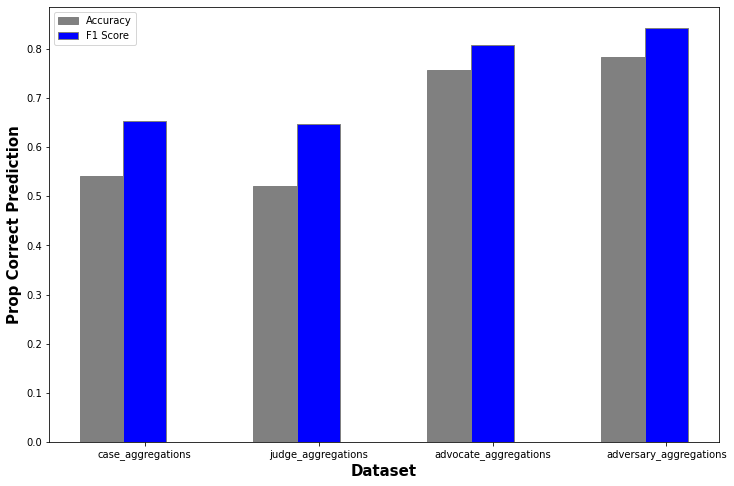

In [19]:
disp_accuracy(acc, labs=list(acc["dataset"]))

### Confusion Matrices
#### Logistic Regression Model - All Utterances

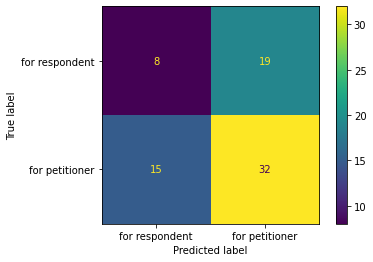

In [20]:
disp_conf_matrix(lr.confusion_matrix["case_aggregations"])

#### Logistic Regression Model - Judge Utterances

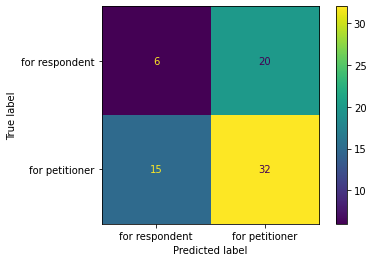

In [21]:
disp_conf_matrix(lr.confusion_matrix["judge_aggregations"])

#### Logistic Regression Model - Advocate Utterances

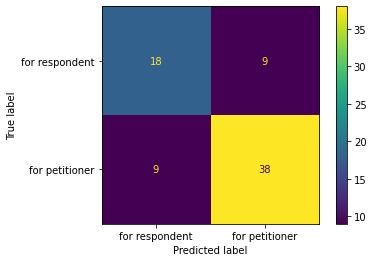

In [22]:
disp_conf_matrix(lr.confusion_matrix["advocate_aggregations"])

#### Logistic Regression Model - Adversary Utterances

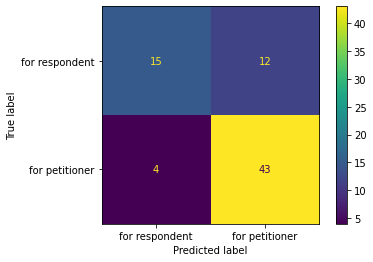

In [23]:
disp_conf_matrix(lr.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

<span style="color:red"><b>[insert plots]</b></span>

## Random Forest
### Default Parameters

- **Maximum Depth**: None
- **Maximum Features**: 5000
- **Number of trees**: 100
- **Test Size**: 0.20

### Accuracies and F1 Score

In [24]:
acc = dict_to_df(["dataset", "accuracy", "f1_score"], rf.accuracies, rf.f1)
acc

,dataset,accuracy,f1_score
0,case_aggregations,0.621622,0.766667
1,judge_aggregations,0.643836,0.783333
2,advocate_aggregations,0.810811,0.862745
3,adversary_aggregations,0.837838,0.880000


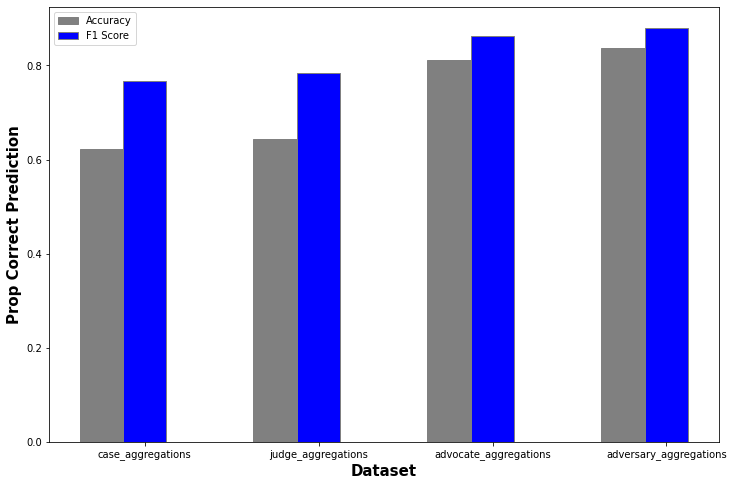

In [25]:
disp_accuracy(acc, labs=acc["dataset"])

### Confusion Matrices
#### Random Forest Model - All Utterances

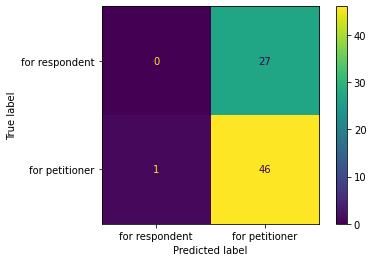

In [26]:
disp_conf_matrix(rf.confusion_matrix["case_aggregations"])

#### Random Forest Model - Judge Utterances

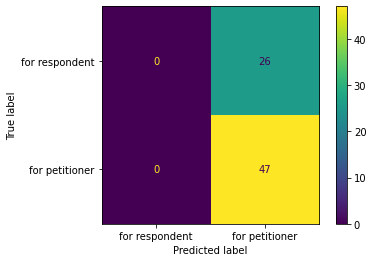

In [27]:
disp_conf_matrix(rf.confusion_matrix["judge_aggregations"])

#### Random Forest Model - Advocate Utterances

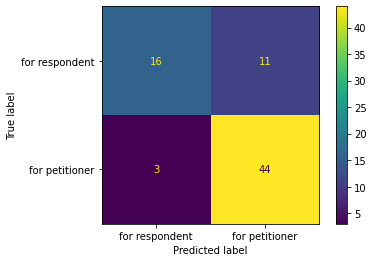

In [28]:
disp_conf_matrix(rf.confusion_matrix["advocate_aggregations"])

#### Random Forest Model - Adversary Utterances

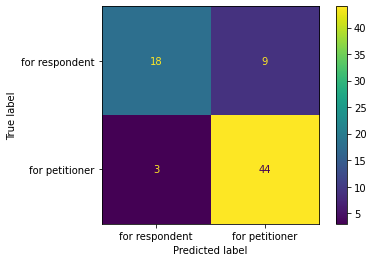

In [29]:
disp_conf_matrix(rf.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

`INSERT PLOTS`

## Gradient Boosted Tree
### Default Parameters

- **Maximum number of features**: 5000
- **Test size**: 0.20
- **Maximum depth**: 7
- **Number of estimators**: 100
- **Learning rate**: 0.3
- **Subsample**: 1

### Accuracies and F1 Score

In [30]:
acc = dict_to_df(["dataset", "accuracy", "f1_score"], xg.accuracies, xg.f1)
acc

,dataset,accuracy,f1_score
0,case_aggregations,0.567568,0.680000
1,judge_aggregations,0.547945,0.697248
2,advocate_aggregations,0.810811,0.860000
3,adversary_aggregations,0.824324,0.863158


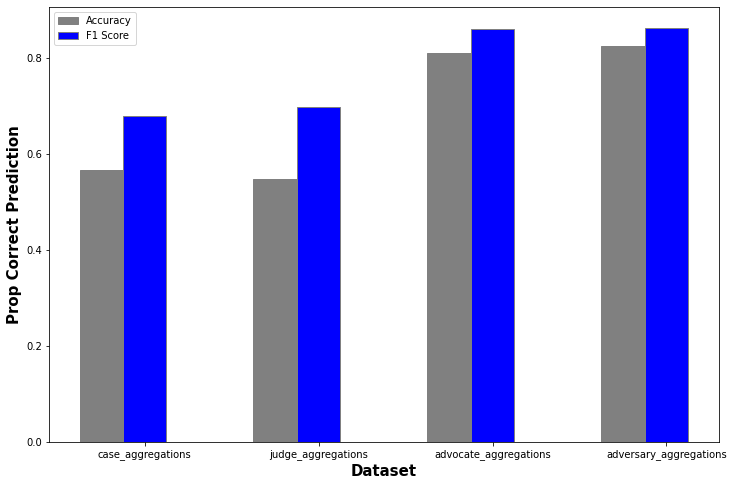

In [32]:
disp_accuracy(acc, labs=acc["dataset"])

### Confusion Matrices
#### Gradient Boosted Tree Model - All Utterances

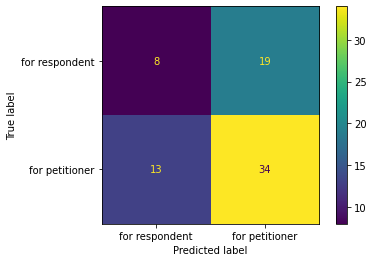

In [33]:
disp_conf_matrix(xg.confusion_matrix["case_aggregations"])

#### Gradient Boosted Tree Model - Judge Utterances

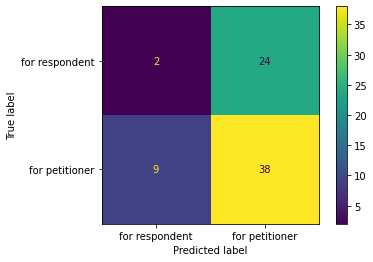

In [34]:
disp_conf_matrix(xg.confusion_matrix["judge_aggregations"])

#### Gradient Boosted Tree Model - Advocate Utterances

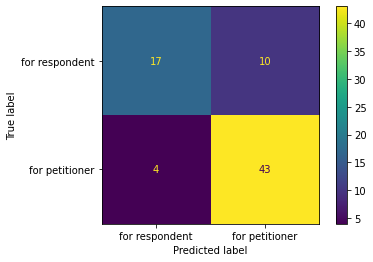

In [35]:
disp_conf_matrix(xg.confusion_matrix["advocate_aggregations"])

#### Gradient Boosted Tree Model - Adversary Utterances

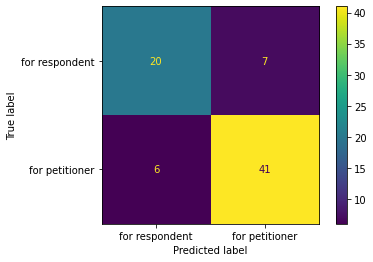

In [36]:
disp_conf_matrix(xg.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

In [38]:
# Create an array of different values to test
eta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
subsample_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#### Eta (Learning Rate) Finetuning

In [43]:
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for eta_value in eta_values:
    xgboost_model = XGBoost(debug_mode=False, eta=eta_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)

print("Done parameter finetuning for eta")

eta_melted, eta_f1_melted = get_long_df(
    "eta", eta_values, accuracy_dicts, f1_dicts
)

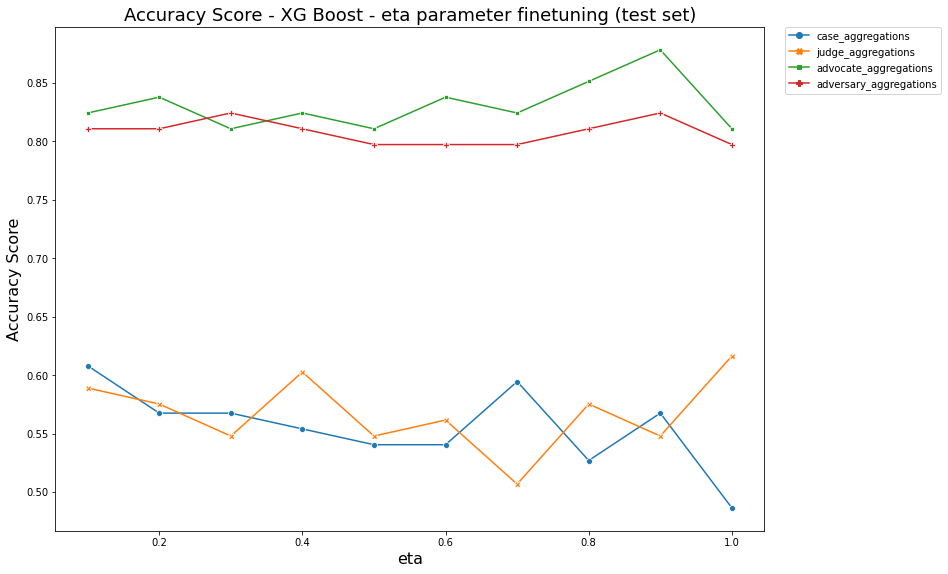

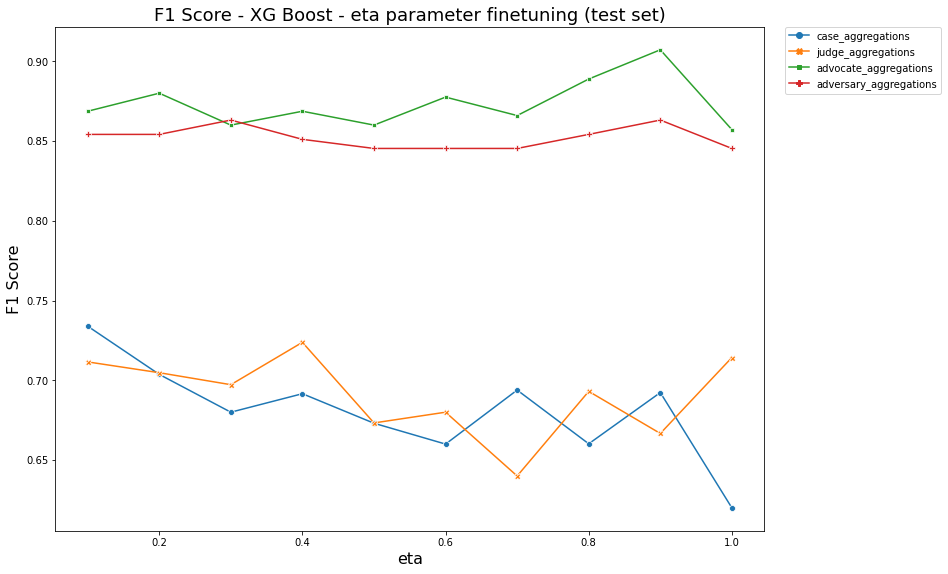

In [46]:
plot_accuracy_scores(eta_melted, "eta", "XG Boost")
plot_accuracy_scores(eta_f1_melted, "eta", "XG Boost", accuracy_metric="F1")

#### Maximum Tree Depth Finetuning

In [47]:
accuracy_dicts = []
f1_dicts = []
confusion_matrix_dicts = []

for max_depth_value in max_depth_values:
    xgboost_model = XGBoost(debug_mode=False, max_depth=max_depth_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)

print("Done parameter finetuning for max_depth")

max_depth_melted, max_depth_f1_melted = get_long_df(
    "Max Tree Depth", max_depth_values, accuracy_dicts, f1_dicts
)

Done parameter finetuning for max_depth


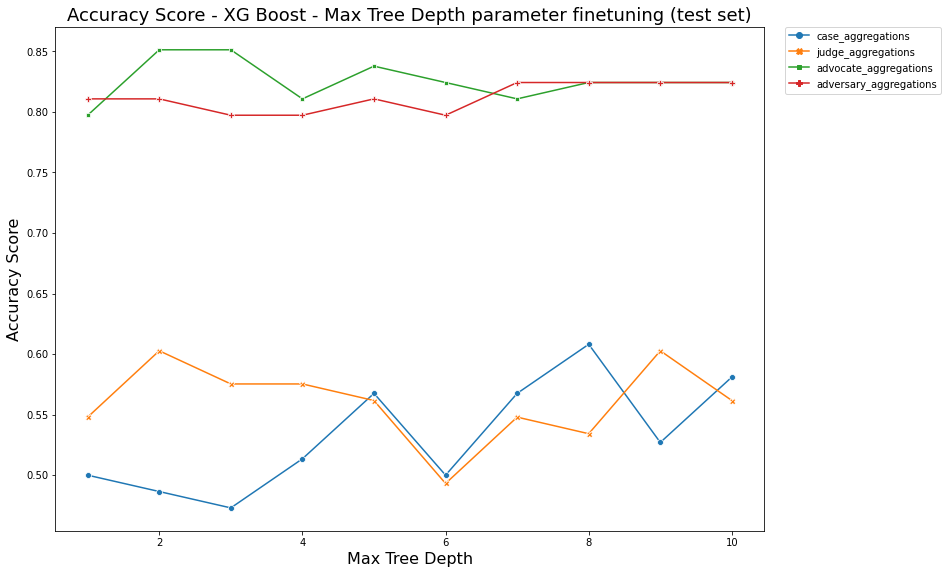

In [48]:
plot_accuracy_scores(max_depth_melted, 'Max Tree Depth', 'XG Boost')
plot_accuracy_scores(max_depth_f1_melted, 'Max Tree Depth', 'XG Boost', accuracy_metric='F1')

<span style="color:red"><b>[insert plots]</b></span>

## Model Comparisons
Using the advocate utterances dataframe as a case study

In [195]:
model_comp

,model,accuracy,f1_score
0,logistic regression,0.783784,0.843137
1,random forest,0.810811,0.860000


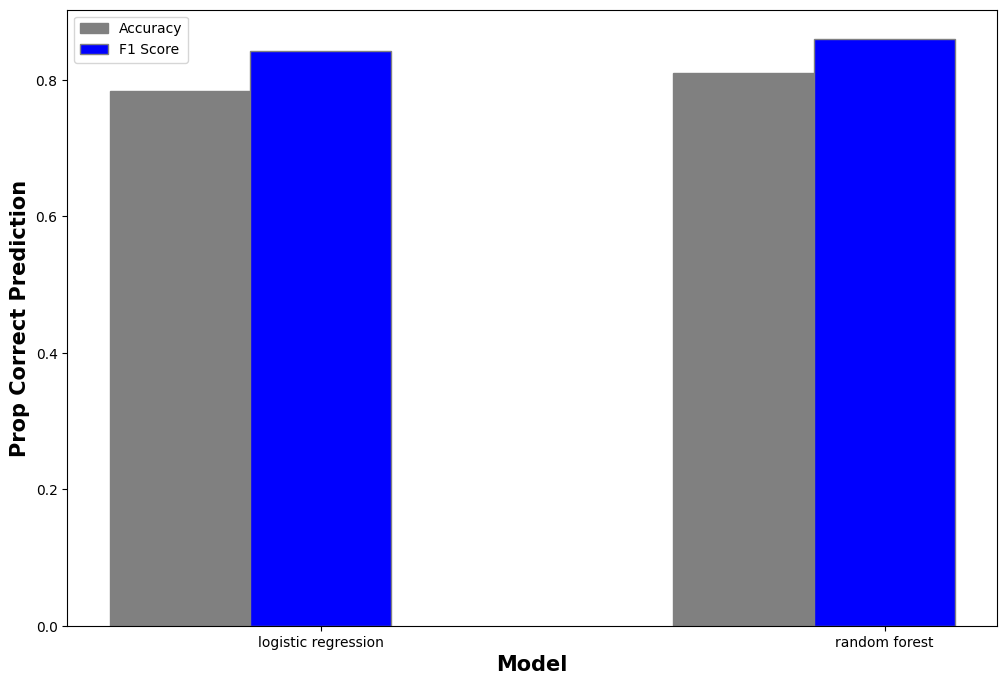

In [196]:
disp_accuracy(model_comp, labs=model_comp["model"], x_label="Model")

## Final Thoughts and Applications

<span style="color:red"><b>[insert]</b></span>

## Thank you!
### Any Questions?